### In this excercise a new image augmentation method is added to Keras. This method manipulates hue, saturation, and lightness of an image. The input is provided as an [H,S,L] triplet of maximum offset values. These values determine the negative and positive bounds of random offsets generated within ImageDataGenerator. Offset ranges mimic those of Photoshop: [-180, 180] for hue, [-100, 100] for saturation, and [-100, 100] for lightness. Transformations between HSL and RGB are implemented as described in Wikipedia: https://en.wikipedia.org/wiki/HSL_and_HSV#General_approach The code sample below demonstrates this method:

Displaying 5 augmented images...

img/original_image.jpg


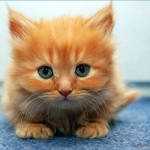

img/augmented_0_9493.jpg


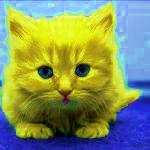

img/augmented_0_7617.jpg


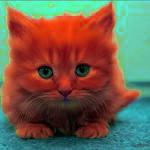

img/augmented_0_6985.jpg


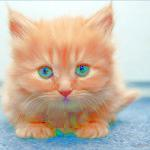

img/augmented_0_2290.jpg


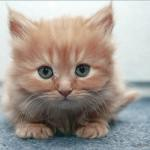

img/augmented_0_1076.jpg


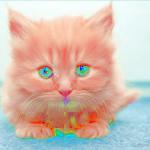

In [4]:
from keras.preprocessing.image_dev import ImageDataGenerator, array_to_img, img_to_array, load_img
from IPython.display import Image
from IPython.display import display
import os

datagen = ImageDataGenerator(
        hsl_max_offsets = [30,70,70] # Hue/Saturation/Lightness offsets
)

img = load_img('img/original_image.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='img',
                          save_prefix='augmented',
                          save_format='jpg'):
    i += 1
    if i >= 5:
        break

path = 'img/'
listing = os.listdir(path)
print ('Displaying %d augmented images...\n' % (i))
for file in reversed(listing):
    if not file == '.ipynb_checkpoints':
        print (path+file)
        img = Image(path+file)
        display(img)


### The original script demonstrating image augmentation is shown below:

In [5]:
'''Trains a simple convnet on the CIFAR10 dataset for ONLY cats and dogs.
The focus of this is to understand image augmentation well enough to do custom work.

So don't worry as much about accuracy, worry more about adding augmentation to the existing method, 
understanding it, explaining it, and if it is significant enough, then trying to merge it into Keras.

TASK DETAILS:
Make a copy of:
from keras.preprocessing.image import ImageDataGenerator

Add functionality to ImageDataGenerator() beyond what is offered. You have flexibility here, one idea would be to add image 
histogram modification methods such as this: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

You are welcome to do anything you want related to ImageDataGenerator to make it better, but histogram modification could be a great
starting point. With your work it helps to show before/after modifications in your notebook/blog. In the end this work is for
you, to help give you visibility, so focus more on something that can be shared on LinkedIn rather than just a notebook. 

13 seconds per epoch on a 2 GHz Intel Core i5.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

batch_size = 64
num_classes = 2
epochs = 10

# input image dimensions
img_rows, img_cols = 32, 32   

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()   

#Only look at cats [=3] and dogs [=5]
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     

y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(np.ravel(y_train), num_classes)
y_test = keras.utils.to_categorical(np.ravel(y_test), num_classes)

model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

augmentation=False

if augmentation==True:
    datagen = ImageDataGenerator(
        rotation_range=0,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=True,
        fill_mode='nearest')
    
    datagen.fit(x_train)
    print("Running augmented training now")
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
else:
    print("Running regular training, no augmentation")
    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples
Running regular training, no augmentation
Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 9s - loss: 0.6926 - acc: 0.5210 - val_loss: 0.6886 - val_acc: 0.5655
Epoch 2/10
10000/10000 [==============================] - 8s - loss: 0.6862 - acc: 0.5460 - val_loss: 0.6773 - val_acc: 0.5760
Epoch 3/10
10000/10000 [==============================] - 9s - loss: 0.6781 - acc: 0.5628 - val_loss: 0.6723 - val_acc: 0.5790
Epoch 4/10
10000/10000 [==============================] - 8s - loss: 0.6749 - acc: 0.5830 - val_loss: 0.6691 - val_acc: 0.5940
Epoch 5/10
10000/10000 [==============================] - 8s - loss: 0.6637 - acc: 0.5972 - val_loss: 0.6625 - val_acc: 0.5905
Epoch 6/10
10000/10000 [==============================] - 10s - loss: 0.6556 - acc: 0.6017 - val_loss: 0.6436 - val_acc: 0.6250
Epoch 7/10
10000/10000 [==============================] - 8s - loss: 0.650

In [1]:
'''Trains a simple convnet on the CIFAR10 dataset for ONLY cats and dogs.
The focus of this is to understand image augmentation well enough to do custom work.

So don't worry as much about accuracy, worry more about adding augmentation to the existing method, 
understanding it, explaining it, and if it is significant enough, then trying to merge it into Keras.

TASK DETAILS:
Make a copy of:
from keras.preprocessing.image import ImageDataGenerator

Add functionality to ImageDataGenerator() beyond what is offered. You have flexibility here, one idea would be to add image 
histogram modification methods such as this: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

You are welcome to do anything you want related to ImageDataGenerator to make it better, but histogram modification could be a great
starting point. With your work it helps to show before/after modifications in your notebook/blog. In the end this work is for
you, to help give you visibility, so focus more on something that can be shared on LinkedIn rather than just a notebook. 

13 seconds per epoch on a 2 GHz Intel Core i5.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

batch_size = 64
num_classes = 2
epochs = 10

# input image dimensions
img_rows, img_cols = 32, 32   

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()   

#Only look at cats [=3] and dogs [=5]
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     

y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(np.ravel(y_train), num_classes)
y_test = keras.utils.to_categorical(np.ravel(y_test), num_classes)

model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

augmentation=True

if augmentation==True:
    datagen = ImageDataGenerator(
        rotation_range=0,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=True,
        fill_mode='nearest')
    
    datagen.fit(x_train)
    print("Running augmented training now")
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
else:
    print("Running regular training, no augmentation")
    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Using TensorFlow backend.


x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples
Running augmented training now
Epoch 1/10
156/156 [==============================] - 8s - loss: 0.6912 - acc: 0.5289 - val_loss: 0.6864 - val_acc: 0.5735
Epoch 2/10
156/156 [==============================] - 7s - loss: 0.6867 - acc: 0.5459 - val_loss: 0.6828 - val_acc: 0.5590
Epoch 3/10
156/156 [==============================] - 8s - loss: 0.6790 - acc: 0.5688 - val_loss: 0.6730 - val_acc: 0.5680
Epoch 4/10
156/156 [==============================] - 8s - loss: 0.6721 - acc: 0.5704 - val_loss: 0.6625 - val_acc: 0.6070
Epoch 5/10
156/156 [==============================] - 8s - loss: 0.6618 - acc: 0.6002 - val_loss: 0.6490 - val_acc: 0.6190
Epoch 6/10
156/156 [==============================] - 8s - loss: 0.6517 - acc: 0.6174 - val_loss: 0.6379 - val_acc: 0.6465
Epoch 7/10
156/156 [==============================] - 8s - loss: 0.6411 - acc: 0.6327 - val_loss: 0.6377 - val_acc: 0.6305
Epoch 8/10
156/156 [================

In [ ]:
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

plt.plot(history.epoch,history.history['val_acc'],'-o',label='validation')
plt.plot(history.epoch,history.history['acc'],'-o',label='training')

plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)

In [1]:
'''Trains a simple convnet on the CIFAR10 dataset for ONLY cats and dogs.
The focus of this is to understand image augmentation well enough to do custom work.

So don't worry as much about accuracy, worry more about adding augmentation to the existing method, 
understanding it, explaining it, and if it is significant enough, then trying to merge it into Keras.

TASK DETAILS:
Make a copy of:
from keras.preprocessing.image import ImageDataGenerator

Add functionality to ImageDataGenerator() beyond what is offered. You have flexibility here, one idea would be to add image 
histogram modification methods such as this: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

You are welcome to do anything you want related to ImageDataGenerator to make it better, but histogram modification could be a great
starting point. With your work it helps to show before/after modifications in your notebook/blog. In the end this work is for
you, to help give you visibility, so focus more on something that can be shared on LinkedIn rather than just a notebook. 

13 seconds per epoch on a 2 GHz Intel Core i5.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from keras.preprocessing.image_dev import ImageDataGenerator

batch_size = 64
num_classes = 2
epochs = 10

# input image dimensions
img_rows, img_cols = 32, 32   

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()   

#Only look at cats [=3] and dogs [=5]
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     

y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(np.ravel(y_train), num_classes)
y_test = keras.utils.to_categorical(np.ravel(y_test), num_classes)

model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

augmentation=True

if augmentation==True:
    datagen = ImageDataGenerator(
        rotation_range=0,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=True,
        fill_mode='nearest',
        hsl_max_offsets=[30,60,60])
    
    datagen.fit(x_train)
    print("Running augmented training now")
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
else:
    print("Running regular training, no augmentation")
    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Using TensorFlow backend.


x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples
Running augmented training now
Epoch 1/10
156/156 [==============================] - 188s - loss: 0.6954 - acc: 0.5166 - val_loss: 0.6902 - val_acc: 0.5415
Epoch 2/10
156/156 [==============================] - 194s - loss: 0.6904 - acc: 0.5254 - val_loss: 0.6842 - val_acc: 0.5505
Epoch 3/10
156/156 [==============================] - 214s - loss: 0.6856 - acc: 0.5475 - val_loss: 0.6756 - val_acc: 0.5780
Epoch 4/10
156/156 [==============================] - 199s - loss: 0.6820 - acc: 0.5638 - val_loss: 0.6679 - val_acc: 0.5885
Epoch 5/10
156/156 [==============================] - 185s - loss: 0.6749 - acc: 0.5855 - val_loss: 0.6662 - val_acc: 0.5960
Epoch 6/10
156/156 [==============================] - 190s - loss: 0.6745 - acc: 0.5752 - val_loss: 0.6626 - val_acc: 0.5880
Epoch 7/10
156/156 [==============================] - 187s - loss: 0.6705 - acc: 0.5902 - val_loss: 0.6596 - val_acc: 0.5840
Epoch 8/10
156/156 [==

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100589). Check your callbacks.
  % delta_t_median)


156/156 [==============================] - 192s - loss: 0.6623 - acc: 0.6006 - val_loss: 0.6543 - val_acc: 0.5995


In [1]:
'''Trains a simple convnet on the CIFAR10 dataset for ONLY cats and dogs.
The focus of this is to understand image augmentation well enough to do custom work.

So don't worry as much about accuracy, worry more about adding augmentation to the existing method, 
understanding it, explaining it, and if it is significant enough, then trying to merge it into Keras.

TASK DETAILS:
Make a copy of:
from keras.preprocessing.image import ImageDataGenerator

Add functionality to ImageDataGenerator() beyond what is offered. You have flexibility here, one idea would be to add image 
histogram modification methods such as this: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

You are welcome to do anything you want related to ImageDataGenerator to make it better, but histogram modification could be a great
starting point. With your work it helps to show before/after modifications in your notebook/blog. In the end this work is for
you, to help give you visibility, so focus more on something that can be shared on LinkedIn rather than just a notebook. 

13 seconds per epoch on a 2 GHz Intel Core i5.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from keras.preprocessing.image_dev import ImageDataGenerator

batch_size = 64
num_classes = 2
epochs = 10

# input image dimensions
img_rows, img_cols = 32, 32   

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()   

#Only look at cats [=3] and dogs [=5]
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     

y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(np.ravel(y_train), num_classes)
y_test = keras.utils.to_categorical(np.ravel(y_test), num_classes)

model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

augmentation=True

if augmentation==True:
    datagen = ImageDataGenerator(
        hsl_max_offsets=[0,50,50])
    
    datagen.fit(x_train)
    print("Running augmented training now")
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
else:
    print("Running regular training, no augmentation")
    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Using TensorFlow backend.


x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples
Running augmented training now
Epoch 1/10
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
imag

image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x3
image size: 32x32 14/156 [=>............................]
 - ETA: 219s - loss: 0.7262 - acc: 0.5045image size: 32x32
im

image size: 32x32
 20/156 [==>...........................] - ETA: 204s - loss: 0.7184 - acc: 0.5008image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
image size: 32x32
i

KeyboardInterrupt: 